In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/CV++/archive.zip

Archive:  /content/gdrive/MyDrive/CV++/archive.zip
  inflating: fer2013.csv             


In [ ]:
import os
import time
import shutil
import random
import cv2
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score

from mlxtend.plotting import plot_confusion_matrix

Tensorflow version 2.9.2


In [ ]:
CATEGORIES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
X = []
y = []
data = pd.read_csv('/content/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


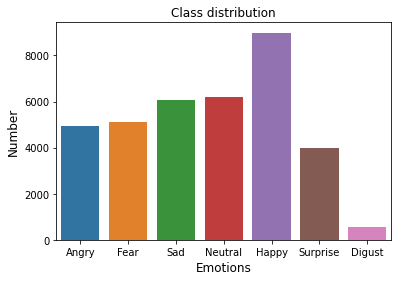

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [ ]:
for index, row in data.iterrows():
    try:
        pixels=np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
        img = pixels.reshape((48,48))
        X.append(img)
        y.append(row['emotion'])
    except Exception as e:
        pass

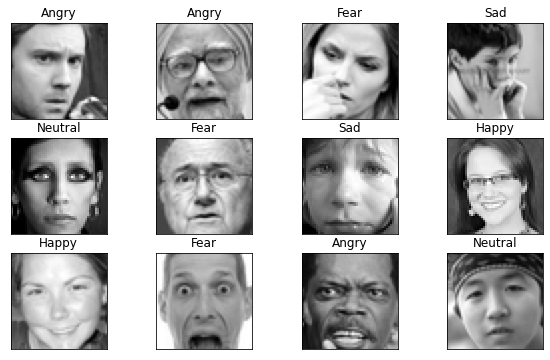

In [ ]:
fig=plt.figure(figsize=(10,6))

for counter, img in enumerate(X[:12]):
    ax = fig.add_subplot(3,4,counter+1)
    ax.imshow(X[counter], cmap='gray')
    plt.title(CATEGORIES[y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
X = np.array(X, dtype='float32').reshape(-1, 48, 48)
rgb_X = np.repeat(X[..., np.newaxis], 3, -1)
rgb_X=rgb_X/255.
y = np.asarray(y)
y.shape

(35887,)

In [ ]:
rgb_X.shape

(35887, 48, 48, 3)

In [ ]:
(X_train, X_val, y_train, y_val) = train_test_split(rgb_X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
X_train.shape

(28709, 48, 48, 3)

In [ ]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

In [ ]:
aug_train.fit(X_train)

generator_val.fit(X_val)

Transfer learning resnet50

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [ ]:
model = Sequential()

pretrained_model = vgg16.VGG16(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                               include_top=False,
                               classes=7,
                               weights='/content/gdrive/MyDrive/CV++/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
#for layer in pretrained_model.layers:
#        layer.trainable=False

model.add(pretrained_model)
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# Output layer
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 14,718,279
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_path = '/content/gdrive/MyDrive/CV++/VGG16_Hist.log'
save_path = '/content/gdrive/MyDrive/CV++/VGG16.h5'

In [ ]:
#checkpoint
checkpoint = ModelCheckpoint(
    save_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
#learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
history = model.fit(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

Epoch 1/50
896/897 [============================>.] - ETA: 0s - loss: 1.8287 - accuracy: 0.2370
Epoch 1: val_accuracy improved from -inf to 0.25049, saving model to /content/gdrive/MyDrive/CV++/VGG16.h5
897/897 [==============================] - 51s 48ms/step - loss: 1.8287 - accuracy: 0.2370 - val_loss: 1.8134 - val_accuracy: 0.2505 - lr: 5.0000e-04
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.8162 - accuracy: 0.2499
Epoch 2: val_accuracy did not improve from 0.25049
897/897 [==============================] - 43s 48ms/step - loss: 1.8162 - accuracy: 0.2498 - val_loss: 1.8125 - val_accuracy: 0.2505 - lr: 5.0000e-04
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 1.8145 - accuracy: 0.2506
Epoch 3: val_accuracy did not improve from 0.25049
897/897 [==============================] - 40s 45ms/step - loss: 1.8145 - accuracy: 0.2506 - val_loss: 1.8128 - val_accuracy: 0.2505 - lr: 5.0000e-04
Epoch 4/50
896/897 [============================>.] -

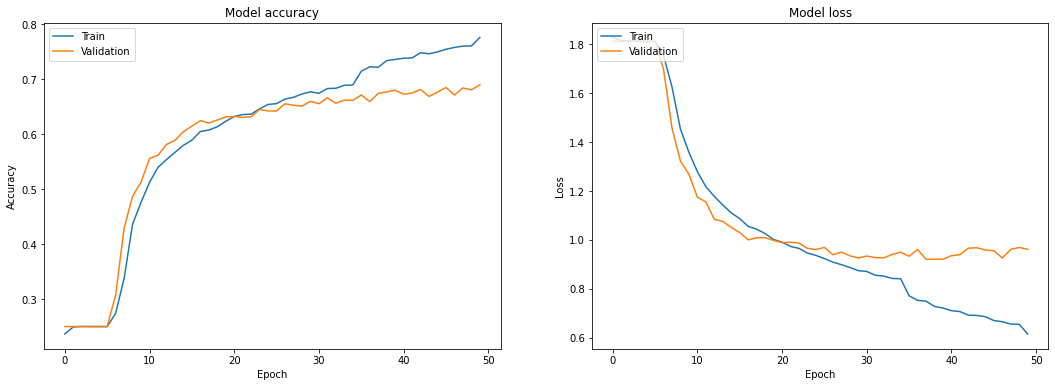

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

225/225 [==============================] - 3s 12ms/step


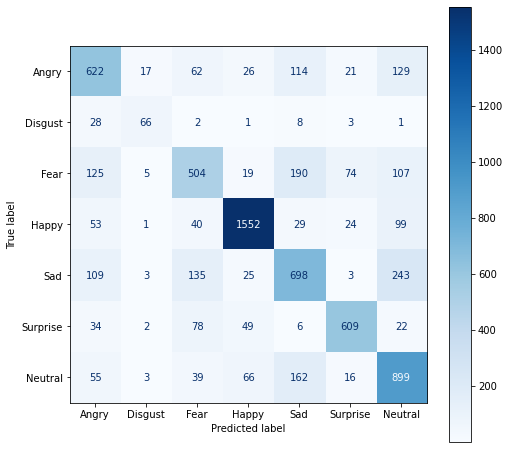

In [ ]:
predicted_label = model.predict(X_val)
predicted_label = np.argmax(predicted_label, axis = 1)
# confusion matrix
c_matrix = confusion_matrix(y_val, predicted_label)
# print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=CATEGORIES)
fig, ax = plt.subplots(figsize=(8,8))
cm_display.plot(cmap=plt.cm.Blues, ax=ax)

In [ ]:
print(classification_report(y_val, predicted_label, target_names = CATEGORIES))

              precision    recall  f1-score   support

       Angry       0.61      0.63      0.62       991
     Disgust       0.68      0.61      0.64       109
        Fear       0.59      0.49      0.54      1024
       Happy       0.89      0.86      0.88      1798
         Sad       0.58      0.57      0.58      1216
    Surprise       0.81      0.76      0.79       800
     Neutral       0.60      0.72      0.66      1240

    accuracy                           0.69      7178
   macro avg       0.68      0.66      0.67      7178
weighted avg       0.69      0.69      0.69      7178

